In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [3]:
data = train[['first_day_of_month','microbusiness_density']].copy(deep=True)
data['Date']=pd.to_datetime(data['first_day_of_month'])
data.drop('first_day_of_month', axis=1, inplace=True)
data.set_index('Date', inplace=True)
data.head()

,microbusiness_density
Date,
2019-08-01,3.01
2019-09-01,2.88
2019-10-01,3.06
2019-11-01,2.99
2019-12-01,2.99


In [4]:
data = data.groupby(data.index).mean()
data.head()

,microbusiness_density
Date,
2019-08-01,3.75
2019-09-01,3.70
2019-10-01,3.78
2019-11-01,3.72
2019-12-01,3.72


In [5]:
data.shape

(39, 1)

In [6]:
train.shape

(122265, 7)

In [7]:
len(np.unique(train[['county', 'state']]))

1921

 * train dataset provided 1921 unique county - state combinations of 39 months.
 * GroupBy according to the date fatures which will help to analyze the dataset.

### Supportive Function to analyze the time series

In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

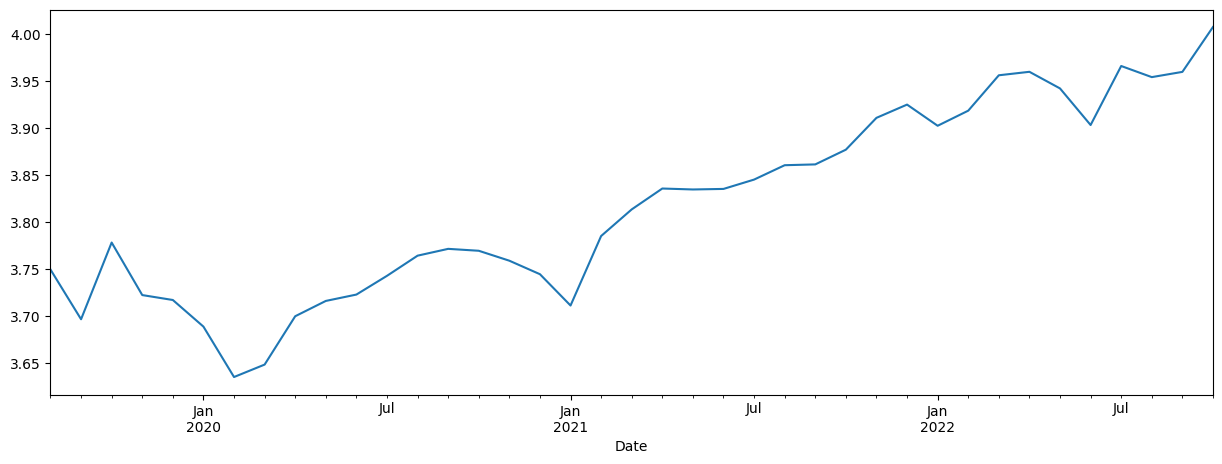

In [10]:
plt.figure(figsize = (15,5))
data['microbusiness_density'].plot();

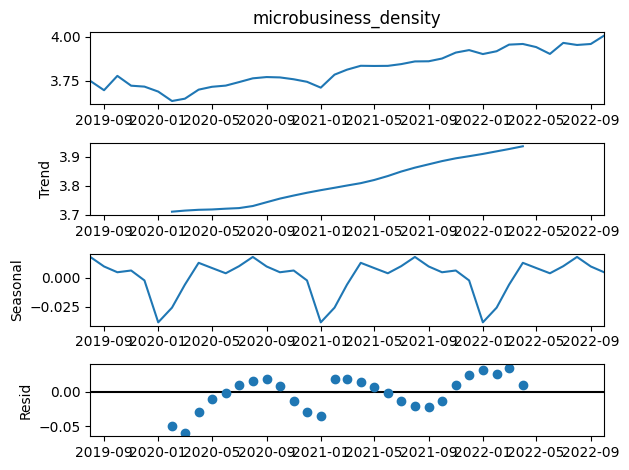

In [11]:
dec = sm.tsa.seasonal_decompose(data['microbusiness_density'], period=12, model='addititve').plot()
plt.show()

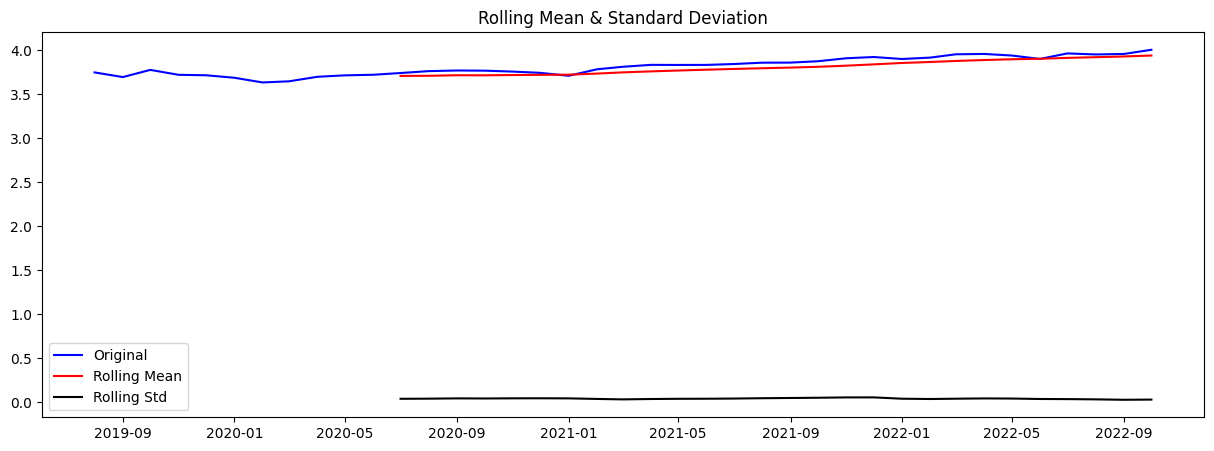

Results of Dickey-Fuller Test:
Test Statistic                -0.18
p-value                        0.94
#Lags Used                     0.00
Number of Observations Used   38.00
Critical Value (1%)           -3.62
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [12]:
test_stationarity(data['microbusiness_density'])

* For the microbusiness_density time series data,
* Rolling Mean is variable with time.
* Rolling Standard Deviation is pretty much flat.
* Test Statistic : (-0.18) > Critical Value (5%) : (-2.94)
* p-value (0.94) > 0.05
* 
From the above information the series is not stationary. For making the series is stationary we will use differencing. 


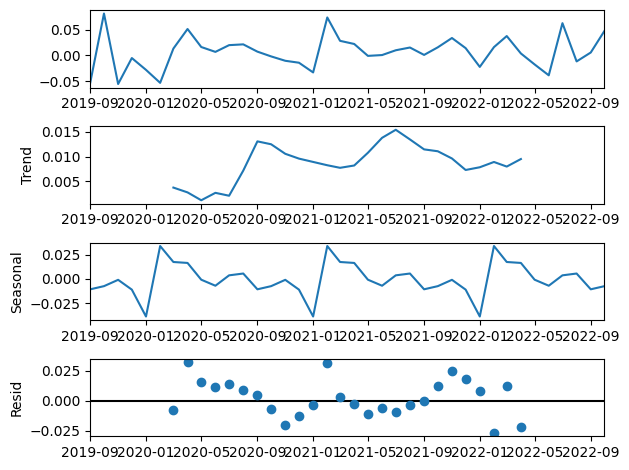

In [13]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff, period=12).plot()
# plt.savefig('sesonal_check_second.jpg')
plt.show()

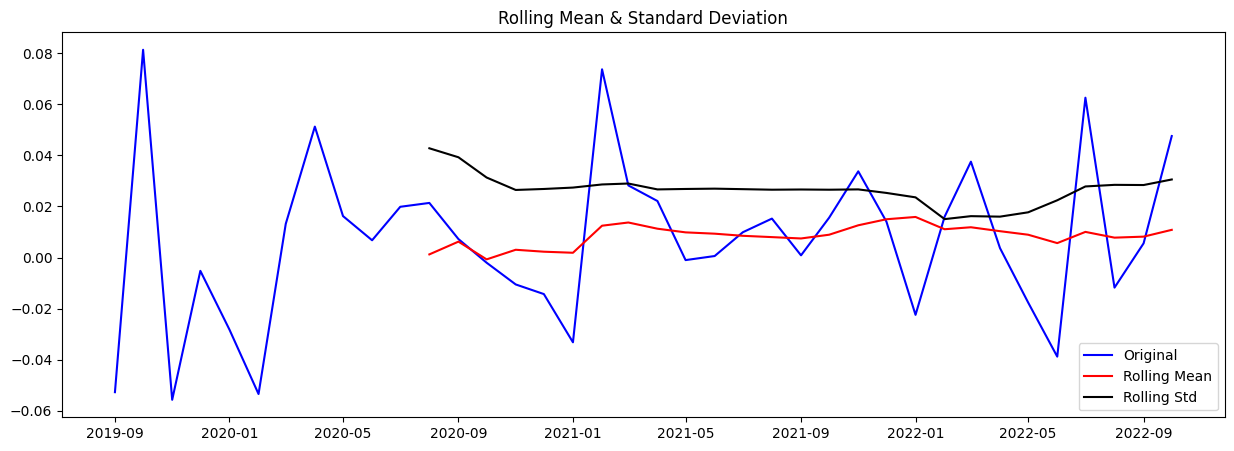

Results of Dickey-Fuller Test:
Test Statistic                -4.59
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [14]:
test_stationarity(data_diff)

From the above information we assume that the series is stationary. now we can assume the order or AR, MA, ARMR, ARIMA, SARIMA by acf and pacf plots

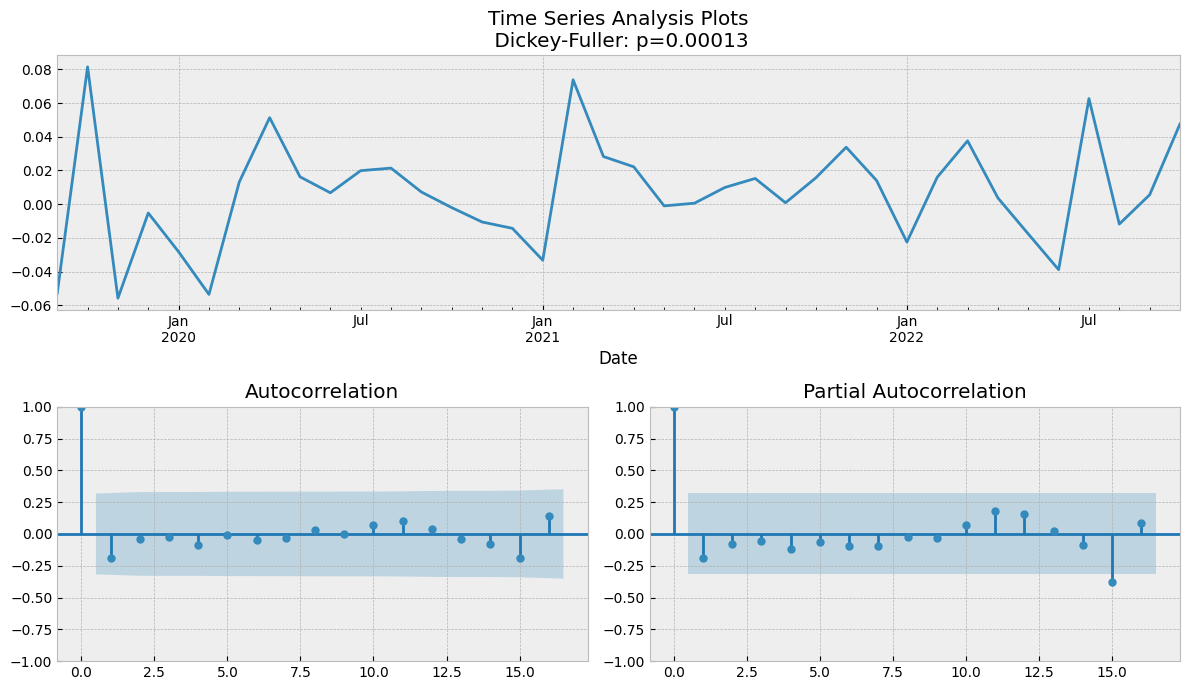

In [15]:
tsplot(data_diff['microbusiness_density'])

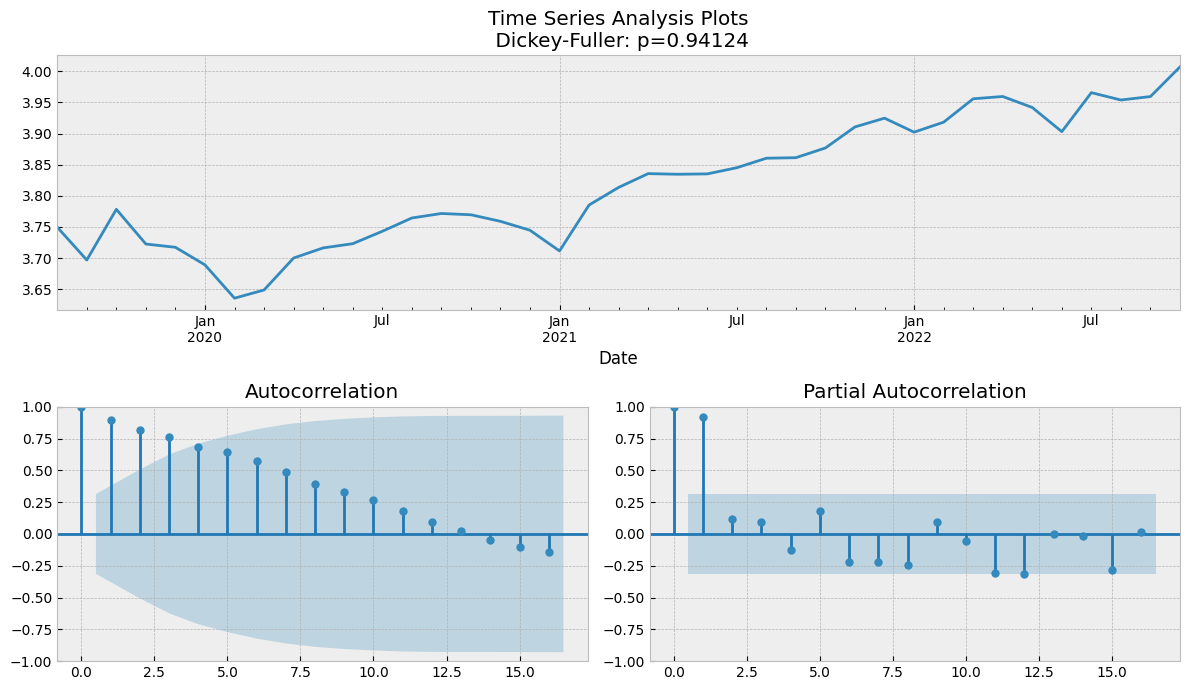

In [16]:
tsplot(data['microbusiness_density'])

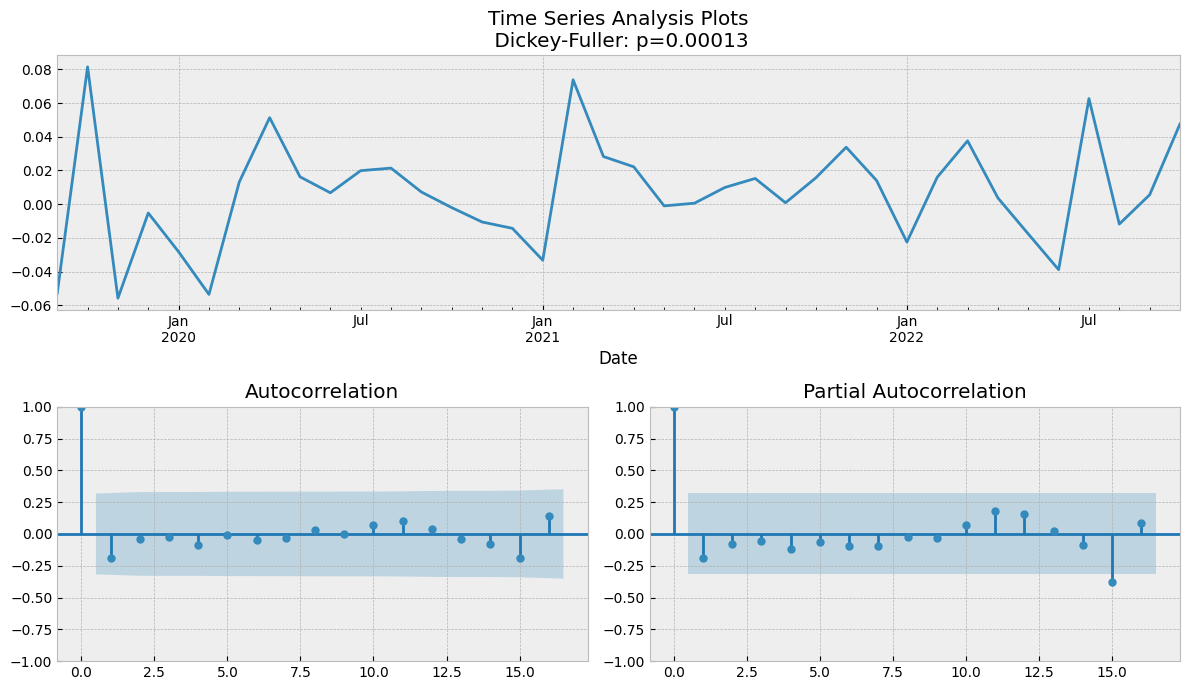

In [17]:
tsplot(data_diff['microbusiness_density'])

## Forecasting Model 

### Training and forecasting by datewise.

In [18]:
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])
df1 = test.copy(deep = True)
df1 = df1.set_index('first_day_of_month')
df1 = df1.groupby(df1.index).mean()
df1

,cfips
first_day_of_month,
2022-11-01,30376.04
2022-12-01,30376.04
2023-01-01,30376.04
2023-02-01,30376.04
2023-03-01,30376.04
2023-04-01,30376.04
2023-05-01,30376.04
2023-06-01,30376.04


In [19]:
history_f = [x for x in data['microbusiness_density']]
f1 = []

for t in tqdm(range(len(df1))):
    
    # model = ARIMA(history_f, order = (0,0,0)) # AR
    # model = ARIMA(history_f, order = (0,0,0)) # MA
    # model = ARIMA(history_f,order = (0,0,0)) # ARMA
    model = ARIMA(history_f, order = (0,1,0)) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    history_f.append(output)
    f1.append(output)
df1['forecast'] = 0
for i in range(len(f1)):
    df1.iloc[i, 1] = f1[i]

df1

 50%|████████████████████████████████████████████████████████                                                        | 4/8 [00:00<00:00, 35.55it/s]D:\time series analysis\time_series_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 29.11it/s]


,cfips,forecast
first_day_of_month,,
2022-11-01,30376.04,4.04
2022-12-01,30376.04,4.05
2023-01-01,30376.04,4.03
2023-02-01,30376.04,4.05
2023-03-01,30376.04,4.09
2023-04-01,30376.04,4.09
2023-05-01,30376.04,4.07
2023-06-01,30376.04,4.03


### Training and forecasting by cfips score

In [20]:
training_data = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
training_data['Date'] = pd.to_datetime(training_data['first_day_of_month'])
training_data.drop(columns = 'first_day_of_month', inplace=True)

training_data = training_data.groupby(['cfips','Date']).sum()
training_data.head()

microbusiness_density
cfips Date                             
1001  2019-08-01                   3.01
      2019-09-01                   2.88
      2019-10-01                   3.06
      2019-11-01                   2.99
      2019-12-01                   2.99

In [26]:
testing_data = test.copy(deep = True)
testing_data['Date'] = pd.to_datetime(testing_data['first_day_of_month'])
testing_data.drop(columns = 'first_day_of_month', inplace=True)

testing_data = testing_data.groupby(['cfips','Date']).sum()
testing_data.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

In [22]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [27]:
testing_data['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in training_data.loc[int(i),:].values]
    f1 = []

    for t in range(len(testing_data.loc[int(i),:])):

        model = ARIMA(history_f, order = (0,0,0)) # AR - MA - ARMA
        model = ARIMA(history_f, order = (0,1,0)) # ARIMA
        model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
        model_fit = model.fit()
        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        testing_data.loc[int(i), 'microbusiness_density'] = f1[j]

testing_data.index = range(0,len(test))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3135/3135 [33:00<00:00,  1.58it/s]


In [28]:
testing_data

,row_id,microbusiness_density
0,1001_2022-11-01,3.61
1,1001_2022-12-01,3.61
2,1001_2023-01-01,3.61
3,1001_2023-02-01,3.61
4,1001_2023-03-01,3.61
...,...,...
25075,56045_2023-02-01,1.92
25076,56045_2023-03-01,1.92
25077,56045_2023-04-01,1.92
25078,56045_2023-05-01,1.92
